In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Entropy, Cross-Entropy and Kullback-Leibler Divergence

**Entropy**

Given $n$ events with probabilities $p = (p_1, \ldots, p_n)$, the uncertainty or entropy associated with the probability distribution $p$ is:
$$
    H(p) = - \sum_i p_i \cdot \log p_i.
$$

**Cross-Entropy**

Suppose $p$ and $q$ are two probability distributions over the same set of events. The cross-entropy of $q$ relative to $p$ is defined as:
$$
    H(p, q) = - \mathbf{E}_p[\log q] = - \sum_{i} p_i \cdot \log q_i.
$$

**Kullback-Leibler Divergence $D_{KL}$**

Suppose that $p$ is the true probability distribution of a set of events and that $q$ is an approximation to $p$. The distance $D_{KL}$ of $q$ from $p$ is defined as:
$$
    D_{KL}(p \mid\mid q) = H(p, q) - H(p) = -\sum_i p_i \cdot \log q_i + \sum_i p_i \cdot \log p_i = \sum_i p_i \cdot \log \frac{p_i}{q_i}.
$$

In [2]:
def entropy(p: np.array) -> float:
    return - np.sum(p * np.log(p))

def kullback_leibler(target: np.array, model: np.array) -> float:
    return np.sum(target * (np.log(target) - np.log(model)))

### Code 7.12

In [3]:
entropy(np.array([0.3, 0.7]))

0.6108643020548935

In [4]:
entropy(np.array([0.01, 0.99]))

0.056001534354847345

In [5]:
entropy(np.array([0.7, 0.15, 0.15]))

0.818808456222877

### Figure 7.5

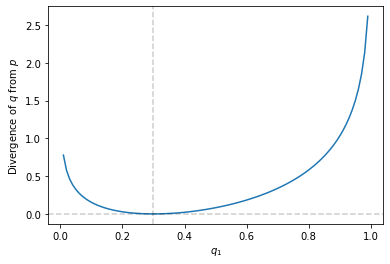

In [6]:
p = np.array([0.3, 0.7])
q_1_vals = np.linspace(0.01, 0.99, 99)
q_2_vals = 1 - q_1_vals

div = []

for q_1, q_2 in zip(q_1_vals, q_2_vals):
    d = kullback_leibler(p, np.array([q_1, q_2]))
    div.append(d)

plt.plot(q_1_vals, div)

plt.axvline(x=0.3, color='k', linestyle='--', alpha=0.2)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.2)

plt.xlabel(r'$q_1$')
plt.ylabel(r'Divergence of $q$ from $p$')

plt.show()

## KL-Divergence is Non-negative

Credit: https://stats.stackexchange.com/questions/335197/why-kl-divergence-is-non-negative

We use the fact that $\log a \leq a - 1$ for all $a > 0$. To show that $D_{KL}(p, q) \geq 0$, it is sufficient to show that $- D_{KL}(p, q) \leq 0$. Now 
\begin{array}
~- D_{KL}(p, q) & = - \sum_i p_i \log \frac{p_i}{q_i} \\
               & = \sum_i p_i \log \frac{q_i}{p_i} \\ 
               & \leq \sum_i p_i \left ( \frac{q_i}{p_i} - 1\right ) \\ 
               & = \sum_{i} (q_i - p_i) = 0.
\end{array}

## The Log-Pointwise-Predictive-Density (LLPD)

For data $y = [y_1, \ldots, y_n]$ and a posterior distribution $\Theta$, the LLPD is defined as:
$$
    \mathrm{llpd} (y, \Theta) = \sum_{i = 1}^{n} \log \frac{1}{S} \sum_{s = 1}^{S} p(y_i \mid \Theta_s),
$$

where

* $S$ is the number of samples

* $\Theta_s$ is the set of parameter values corresponding to the $s$th sample from the posterior distribution.

To create the LLPD computation, we recreate the data for the brain-body mass experiments. 

In [7]:
sppnames = ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens']
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]

df = pd.DataFrame({'species': sppnames, 'brain': brainvolcc, 'mass': masskg})

df['mass_std'] = (df['mass'] - df['mass'].mean()) / df['mass'].std()
df['brain_std'] = df['brain'] / df['brain'].max()

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
from scipy import stats
from scipy.special import logsumexp

In [9]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=df).fit()

In [10]:
pd.DataFrame(m_7_1.params)

,0
Intercept,0.528677
mass_std,0.167118


In [11]:
m_7_1.cov_params()

,Intercept,mass_std
Intercept,4.980017e-03,3.981467e-19
mass_std,3.981467e-19,5.810020e-03


### First create the parameters of the distribution

In our case, this amounts to creating the mean and the standard deviations of a multivariate normal distribution from which the `brain_std` are obtained.

In [12]:
N_SPECIES = 7
N_SAMPLES = 3000

samples = stats.multivariate_normal(m_7_1.params, m_7_1.cov_params()).rvs(N_SAMPLES) # (N_SAMPLES, 2)

intercept = samples[:, 0] # (N_SAMPLES, )
slope = samples[:, 1] # (N_SAMPLES, )

body_mass_std = df.mass_std.values.reshape(-1, 1)  # (7, 1)
brain_vol_std = df.brain_std.values.reshape(-1, 1)  # (7, 1)

slope = slope.reshape(1, N_SAMPLES)
intercept = intercept.reshape(1, N_SAMPLES)

# broadcasting going on here
pred_means = intercept + body_mass_std * slope  # (7, N_SAMPLES)

# At this point, each column of pred is one sample for each of the seven species.
# For each sample, take the standard deviations of the brain_vol predictions of all 7 species. 
# This corresponds to taking the standard deviation for the entries of each column (axis=0).

# pred_mean: (7, N_SAMPLES), brain_vol_std: (7, 1) -> broadcasting going on here
sq_diff = (pred_means - brain_vol_std)**2 # (N_SPECIES, N_SAMPLES)
col_wise_sums = np.sum(sq_diff, axis=0) # (N_SAMPLES, )
pred_sigmas = np.sqrt(col_wise_sums / N_SPECIES) # (N_SAMPLES, )

### Next calculate the LLPD for each species

This corresponds to the following steps:

1. Compute the pdf for each sample of parameters from the posterior distribution: $p(y_i \mid \Theta_s)$

2. For each species, take the sum $\sum_s p(y_i \mid \Theta_s)$ over all samples $s$, divide by the number of samples $S$.

3. Finally take logs.

In [13]:
ll = np.zeros(shape=(N_SPECIES, N_SAMPLES))

for s in range(N_SAMPLES):
    ll[:, s] = stats.norm.pdf(x=df.brain_std, loc=pred_means[:, s], scale=pred_sigmas[s])

lppd = np.zeros(N_SPECIES)

for i in range(N_SPECIES):
    lppd[i] = np.log(np.sum(ll[i]) / N_SAMPLES) 
lppd

array([ 0.62452583,  0.66369902,  0.56018554,  0.630427  ,  0.47592397,
        0.4453055 , -0.8463082 ])